In [1]:
import argparse
import collections
import numpy as np
import pyro
import torch
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
import trainer.trainer as module_trainer

In [2]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [3]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [4]:
def main(config):
    logger = config.get_logger('train')

    # setup data_loader instances
    data_loader = config.init_obj('data_loader', module_data)
    valid_data_loader = data_loader.split_validation()

    # build model architecture, then print to console
    model = config.init_obj('arch', module_arch)
    logger.info(model)

    # build optimizer.
    optimizer = config.init_obj('optimizer', pyro.optim)

    # build trainer
    # kwargs = config['trainer'].pop('args')
    trainer = config.init_obj('trainer', module_trainer, model, [], optimizer,
                              config=config, data_loader=data_loader,
                              valid_data_loader=valid_data_loader,
                              lr_scheduler=None)

    trainer.train()
    return trainer

In [5]:
from utils import read_json

config = read_json("ppc_mnist_config.json")
config = ConfigParser(config)
trained = main(config)

MnistPpc(
  (digit_features): DigitFeatures()
  (decoder): DigitDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=400, bias=True)
      (3): ReLU()
      (4): Linear(in_features=400, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)
Trainable parameters: 396984
Train Epoch: 1 [0/54000 (0%)] Loss: 16.096043
Train Epoch: 1 [11264/54000 (21%)] Loss: -1385.956787
Train Epoch: 1 [22528/54000 (42%)] Loss: -1364.028687
Train Epoch: 1 [33792/54000 (63%)] Loss: -1445.523438
Train Epoch: 1 [45056/54000 (83%)] Loss: -1417.136230
    epoch          : 1
    loss           : -1370.7019707661755
    log_marginal   : 1370.7019696145687
    val_loss       : -1456.5855611165364
    val_log_marginal: 1456.5855611165364
Saving checkpoint: saved/models/Mnist_Ppc/0102_234206/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Train Epoch: 2 [0/54000 (0%)] Loss: -1424.2

In [6]:
trained.model.eval()
trained.model.cpu()

MnistPpc(
  (digit_features): DigitFeatures()
  (decoder): DigitDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=200, bias=True)
      (1): ReLU()
      (2): Linear(in_features=200, out_features=400, bias=True)
      (3): ReLU()
      (4): Linear(in_features=400, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [8]:
t0 = trained._train_traces[0]

In [9]:
with pyro.poutine.replay(trace=t0):
    with pyro.plate_stack("forward", (8, 512)):
        xs = trained.model()

In [10]:
import matplotlib.pyplot as plt

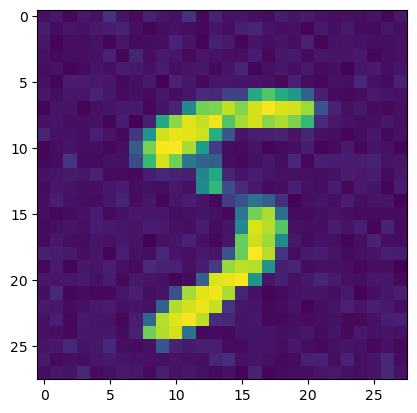

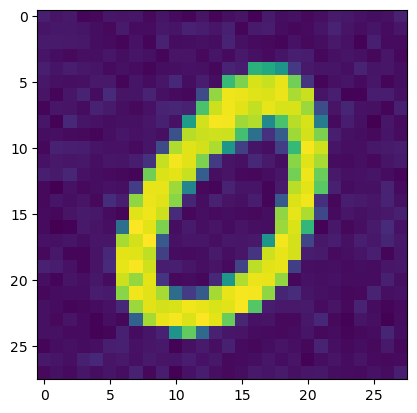

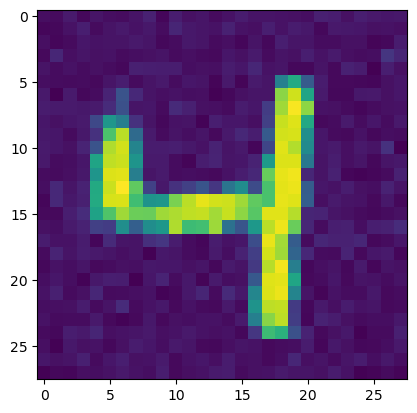

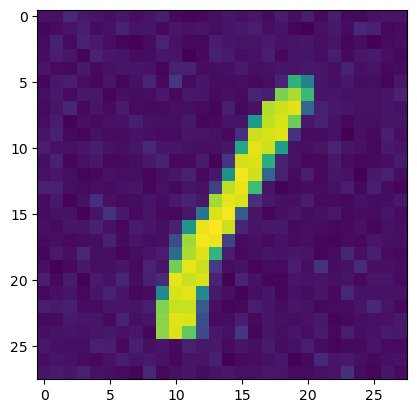

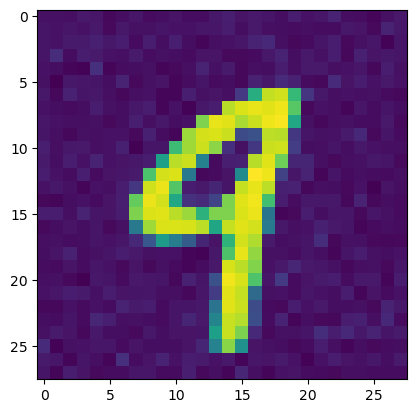

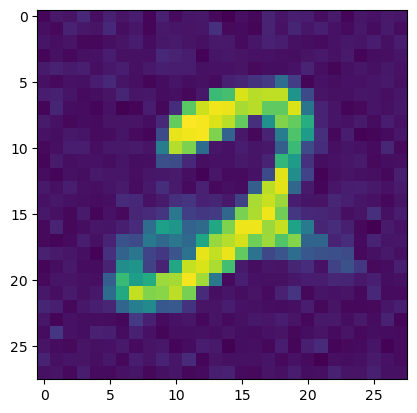

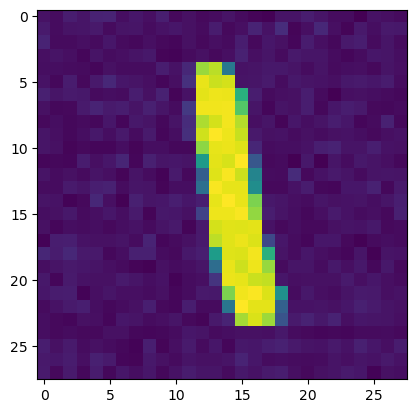

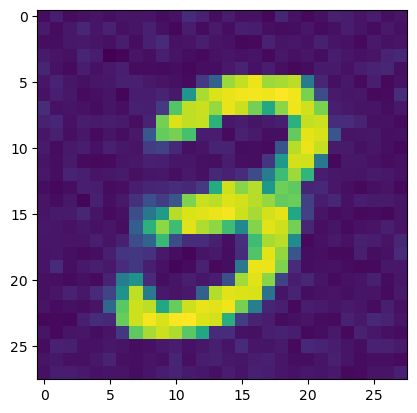

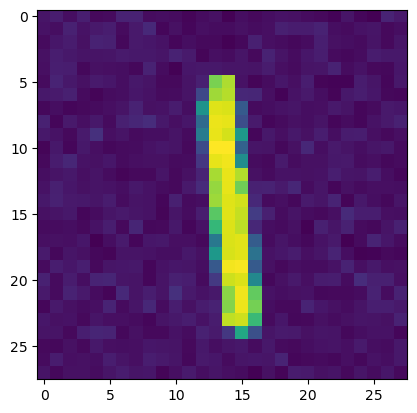

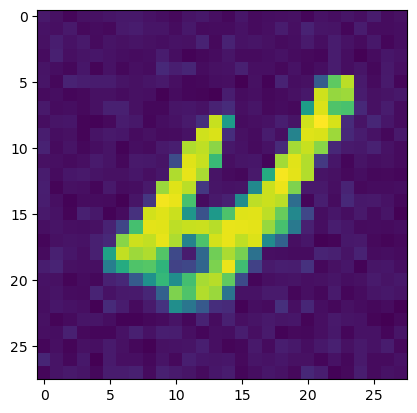

In [11]:
for i in range(10):
    plt.imshow(xs.mean(dim=0)[i].squeeze().detach().numpy())
    plt.show()